https://neuralprophet.com/

### When to Use NeuralProphet

NeuralProphet can produce both single step and multi step-ahead forecasts. At the moment, NeuralProphet builds models univariately. This means that if you have many series that you expect to produce forecasts for, you need to do this one at a time. However, in future we hope to integrate the capability of global forecasting models into NeuralProphet.

NeuralProphet helps build forecasting models for scenarios where there are other external factors which can drive the behaviour of the target series over time. Using such external information can heavily improve forecasting models rather than relying only on the autocorrelation of the series. NeuralProphet tool is suitable for forecasting practitioners that wish to gain insights into the overall modelling process by visualizing the forecasts, the individual components as well as the underlying coefficients of the model. Through our descriptive plots, users can visualize the interaction of the individual components. They also have the power to control these coefficients as required by introducing sparsity through regularization. They can combine the components additively or multiplicatively as per their domain knowledge.

# Setting up notebook

In [ ]:
pip install git+https://github.com/ourownstory/neural_prophet.git

  Cloning https://github.com/ourownstory/neural_prophet.git to /tmp/pip-req-build-dhf64f1x
  Running command git clone -q https://github.com/ourownstory/neural_prophet.git /tmp/pip-req-build-dhf64f1x
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet, set_log_level

pd.options.display.float_format='{:,.4f}'.format

# Uploading dataset

In [ ]:
df_original = pd.read_csv('/content/ts_kwh_dataframe.csv')
df_original = df_original.drop('Unnamed: 0', axis = 1)
#df_original

In [ ]:
df_original.describe()

,kW/h price mean,kW/h price std,Disponibilidad_HIDRAULICA,Disponibilidad_TERMICA,Disponibilidad_SOLAR,Aportes Caudal m3/s,Aportes Energía gWh,Volumen Útil Diario Mm3,Volumen Mm3,Volumen Útil Diario Energía gWh,Volumen Energía gWh,Vertimientos Volumen miles m3,Vertimiento Energía gWh
count,"7,866.0000","7,866.0000","7,866.0000","7,866.0000",731.0000,"7,866.0000","7,866.0000","7,866.0000","7,866.0000","7,866.0000","7,866.0000","4,945.0000","4,945.0000"
mean,135.6252,18.2195,191.5593,92.3581,0.7355,"1,699.2571",140.8939,"6,309.8131","8,261.7664","10,519.6631","11,715.5082","11,859.7959",11.3155
std,134.5370,22.1098,21.5015,14.0937,0.4737,749.8535,70.4382,"1,892.3548","2,262.7321","1,983.6521","2,008.1893","18,656.4698",17.3853
min,28.8414,0.0000,0.0000,0.0000,0.0023,0.0000,25.2534,"2,229.8790","4,051.0550","5,405.0078","6,907.0382",0.0000,0.0000
25%,65.6000,5.2340,175.2980,85.3941,0.3691,"1,153.0747",89.5840,"5,049.4127","6,736.0645","9,151.4417","10,281.0671",992.5660,0.8195
50%,93.8549,11.9509,185.7926,93.6778,0.4500,"1,622.6130",129.9833,"5,967.7160","7,731.4585","10,742.6588","11,907.8903","4,732.1300",4.0155
75%,159.7140,23.4903,207.3736,99.3840,1.2000,"2,103.8440",175.8679,"6,988.9313","8,938.8250","12,167.0539","13,348.1890","14,010.8600",14.1713
max,"1,942.6928",462.0501,249.0059,148.5874,1.6080,"6,088.9140",591.2453,"12,155.4460","14,888.8860","14,501.5791","15,972.6098","153,542.8180",140.5255


In [ ]:
pd.DataFrame(df_original.isna().sum(), columns=['Missings'])

,Missings
Fecha,0
kW/h price mean,0
kW/h price std,0
Disponibilidad_HIDRAULICA,0
Disponibilidad_TERMICA,0
Disponibilidad_SOLAR,7135
Aportes Caudal m3/s,0
Aportes Energía gWh,0
Volumen Útil Diario Mm3,0
Volumen Mm3,0


In [ ]:
df = df_original[['Fecha','kW/h price mean']].copy()
df.columns = ['ds','y']

#Forecasting

To predict multiple steps into the future, we could 'unroll' our single-step model, by predicting a step ahead, adding the forecasted value to our data, and then forecasting the next step until we reach the horizon we are interested in. However, there is a better way to do this: We can directly forecast multiple steps ahead with NeuralProphet.

We can set n_forecasts to the desired number of steps we would like to forecast (also known as 'forecast horizon'). NeuralProphet will forecast n_forecasts steps into the future, at every single step. Thus, we have n_forecasts overlapping predictions of vaying age at every historic point.

When icreasing the forecast horizon n_forecasts, we should also increase the number of past observations n_lags to at least the same value.

In [ ]:
#df = df.reset_index()
model = NeuralProphet(
    n_lags=12,
    n_forecasts=730,
    changepoints_range=0.95,
    n_changepoints=17,
    weekly_seasonality=False,
    batch_size=32,
    epochs=10,
    learning_rate=0.5,
    daily_seasonality="auto",
    seasonality_mode="additive"
)
metrics = model.fit(df, freq='D')

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[10/10]: 100%|██████████| 10/10 [00:27<00:00,  2.72s/it, SmoothL1Loss=0.0302, MAE=45.9, MSE=7.54e+3, RegLoss=0]


The automatic selection of hyperparameters may not lead to ideal results. Consider changing them manually.

The automatically set hyperparameters (printed out as 'INFO' level logs) can serve as a good starting point.

In [ ]:
metrics

,SmoothL1Loss,MAE,MSE,RegLoss
0,0.1555,118.4618,"41,028.4784",0.0000
1,0.0707,73.2369,"19,353.2586",0.0000
2,0.1309,107.1554,"43,266.7407",0.0000
3,0.1360,111.4733,"43,255.0572",0.0000
4,0.1011,91.6591,"30,341.2081",0.0000
5,0.0827,81.3700,"23,458.5669",0.0000
6,0.0591,67.0434,"15,421.1310",0.0000
7,0.0390,53.7637,"9,618.5368",0.0000
8,0.0327,48.5973,"8,113.6786",0.0000
9,0.0302,45.8910,"7,541.9022",0.0000


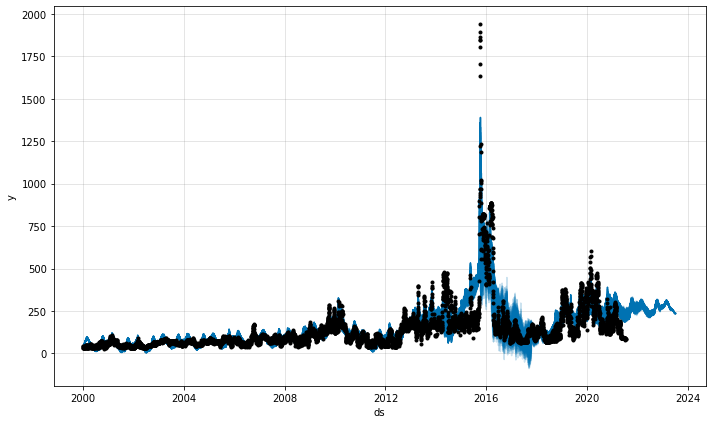

In [ ]:
future = model.make_future_dataframe(df, n_historic_predictions=True)
forecast = model.predict(future)
fig = model.plot(forecast)

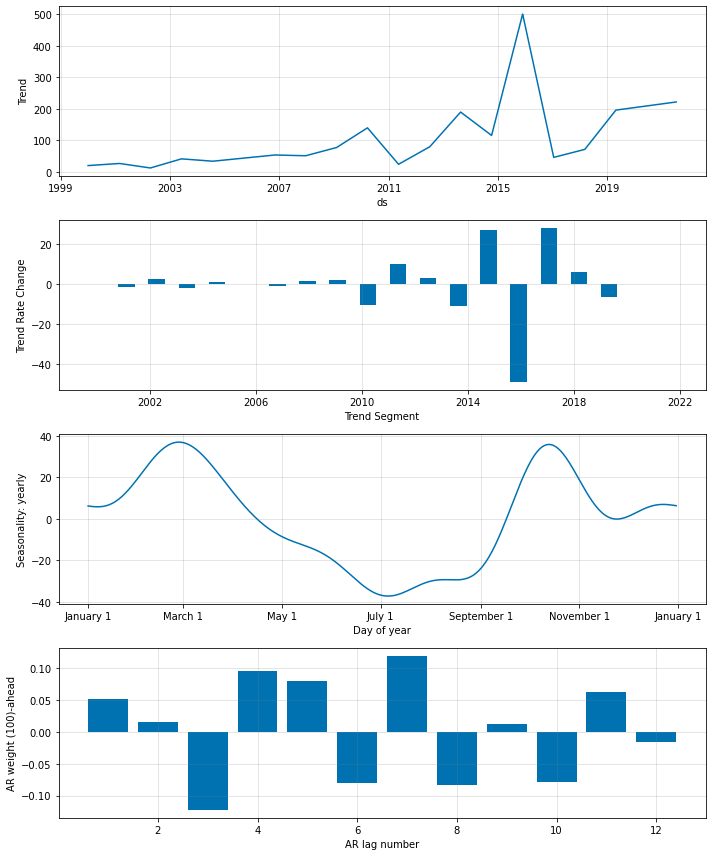

In [ ]:
# fig_comp = m.plot_components(forecast)
m = model.highlight_nth_step_ahead_of_each_forecast(100) # temporary workaround to plot actual AR weights
fig_param = m.plot_parameters()

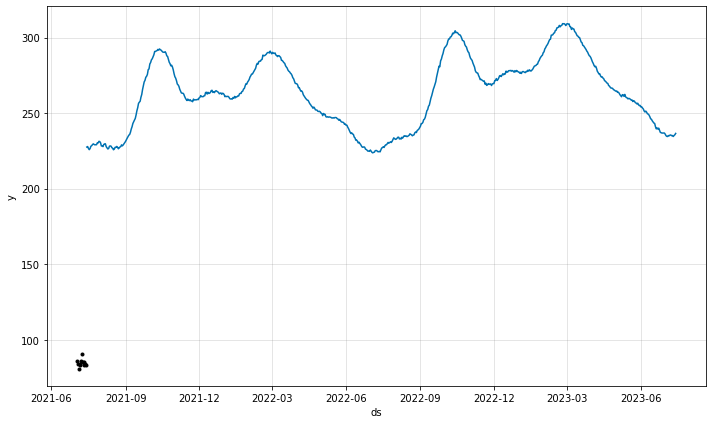

In [ ]:
m = model.highlight_nth_step_ahead_of_each_forecast(None) # reset highlight
fig = m.plot_last_forecast(forecast)

In [ ]:
forecast

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,yhat5,residual5,yhat6,residual6,yhat7,residual7,yhat8,residual8,yhat9,residual9,yhat10,residual10,yhat11,residual11,yhat12,residual12,yhat13,residual13,yhat14,residual14,yhat15,residual15,yhat16,residual16,yhat17,residual17,yhat18,residual18,yhat19,residual19,...,ar693,ar694,ar695,ar696,ar697,ar698,ar699,ar700,ar701,ar702,ar703,ar704,ar705,ar706,ar707,ar708,ar709,ar710,ar711,ar712,ar713,ar714,ar715,ar716,ar717,ar718,ar719,ar720,ar721,ar722,ar723,ar724,ar725,ar726,ar727,ar728,ar729,ar730,trend,season_yearly
0,2000-01-01,32.8681,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,2000-01-02,33.0348,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,2000-01-03,37.2723,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,2000-01-04,41.6890,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,2000-01-05,40.8931,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8591,2023-07-10,nan,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,-1.9946,-2.3733,-2.5379,-2.2633,-2.7649,274.0862,-36.9480
8592,2023-07-11,nan,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,-2.8301,-2.6750,-2.7869,-1.4538,274.1183,-36.7737
8593,2023-07-12,nan,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,

In [ ]:
forecast['adj'] = forecast['yhat730'] - 140
forecast_df = forecast[['adj']][7800:].astype(float)
forecast_df['Date'] = forecast['ds'][7800:]
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])
forecast_df = forecast_df.set_index('Date')
forecast_df

,adj
Date,
2021-05-10,95.1109
2021-05-11,88.3863
2021-05-12,88.2724
2021-05-13,90.3096
2021-05-14,87.8101
...,...
2023-07-10,94.3734
2023-07-11,95.8907
2023-07-12,95.9744


In [ ]:
forecast_df.to_excel('neural prophet.xlsx')

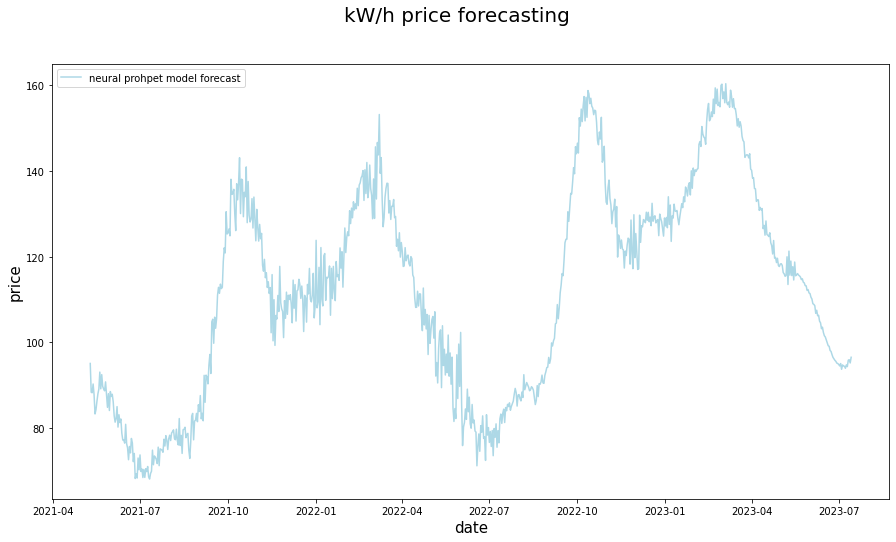

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(data=forecast_df, y='adj', color='lightblue', x = 'Date', label='neural prohpet model forecast')
fig.suptitle('kW/h price forecasting',fontsize=20)
plt.xlabel('date',fontsize=15)
plt.ylabel('price',fontsize=15)
fig.savefig('forecast.jpg')

# Comparing results

In [ ]:
df2 = pd.read_excel('/content/forecasting_arima_sarimax.xlsx')
df2.columns

In [ ]:
forecast_df_test = pd.read_excel('/content/price_multivarite_forecast.xlsx')
forecast_df_test = forecast_df_test.drop('Unnamed: 0', axis=1)
forecast_df_test.columns = ['multivariate model forecast']
forecast_df_test['univariate model forecast'] = df2['univariate model forecast']
forecast_df_test['date'] = pd.date_range(start='15/7/2021', periods=len(forecast_df_test), freq='D')
forecast_df_test['date'] = pd.to_datetime(forecast_df_test['date'])
forecast_df_test = forecast_df_test.set_index('date')
forecast_df_test

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(data=forecast_df_test, y='multivariate model forecast', color='green', x = 'date', label='multivariate model forecast')
sns.lineplot(data=df2, y='univariate model forecast', color='blue', x = 'date', label='univariate model forecast')
sns.lineplot(data=forecast_df[-731:], y='adj', color='orange', x = 'Date', label='neural prohpet model forecast')
plt.xlabel('date',fontsize=15)
plt.ylabel('price',fontsize=15)
fig.savefig('forecast.jpg')

In [ ]:
forecast_df[['adj']][-731:]

In [ ]:
forecast_df_test['neural prophet'] = forecast_df['adj'][-731:]
forecast_df_test['mean forecast'] = (forecast_df_test['neural prophet'] + forecast_df_test['univariate model forecast'] + forecast_df_test['multivariate model forecast'])/3
forecast_df_test

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(data=forecast_df_test, y='multivariate model forecast', color='green', x = 'date', label='multivariate model forecast')
sns.lineplot(data=df2, y='univariate model forecast', color='blue', x = 'date', label='univariate model forecast')
sns.lineplot(data=forecast_df[-731:], y='adj', color='orange', x = 'Date', label='neural prohpet model forecast')
sns.lineplot(data=forecast_df_test, y='mean forecast', color='red', x = 'date', label='mean forecast')
fig.suptitle('kW/h price forecasting',fontsize=20)
plt.xlabel('date',fontsize=15)
plt.ylabel('price',fontsize=15)
fig.savefig('forecast.jpg')

# Validation

In [ ]:
m = NeuralProphet()
df_train, df_val = m.split_df(df, valid_p=0.2, freq='D')

In [ ]:
train_metrics = m.fit(df_train, freq='D')
val_metrics = m.test(df_val)

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 114


  0%|          | 0/289 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.65E-02, min: 6.49E-01
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 2.49E-01
Epoch[114/114]: 100%|██████████| 114/114 [00:33<00:00,  3.38it/s, SmoothL1Loss=0.0549, MAE=45.2, MSE=1.24e+4, RegLoss=0]
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE       MSE
1         0.084 102.989 13143.704


In [ ]:
val_metrics

,SmoothL1Loss,MAE,MSE
0,0.0844,102.9885,"13,143.7040"


In [ ]:
train_metrics

,SmoothL1Loss,MAE,MSE,RegLoss
0,0.4447,226.6227,"88,302.4035",0.0000
1,0.0853,76.9314,"17,570.9755",0.0000
2,0.0637,57.0809,"14,108.5370",0.0000
3,0.0616,53.4260,"13,728.4228",0.0000
4,0.0604,51.7616,"13,459.7374",0.0000
...,...,...,...,...
109,0.0553,45.8986,"12,471.7599",0.0000
110,0.0551,45.4796,"12,484.0313",0.0000
111,0.0550,45.0927,"12,457.0623",0.0000
112,0.0549,45.3094,"12,412.5700",0.0000
